# Spectral timing products

This tutorial shows how nDspec handles standard spectral-timing products. It assumes some a-priori knowledge of accreting black holes and their X-ray spectra. 

In [1]:
import sys
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from pyfftw.interfaces.numpy_fft import (
    fftfreq,
)
from astropy.io import fits

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

from ndspec.Response import ResponseMatrix
from ndspec.Timing import PowerSpectrum, CrossSpectrum
import ndspec.models as models

## Defining a power spectrum from a model time series

In nDspec, the power spectrum is handled by a dedicated class, ````PowerSpectrum````. This class requires an array of times (over which our model will be defined) to be instantiated. By default, the class constructor will them compute and store the corresponding array of (positive) Fourier frequencies ````freqs````. After instantiation, users can pass a time domain model array through the ````compute_psd```` method to calculate the power spectrum of that signal. This power spectrum is stored in the ````power_spec```` attribute.

In this example, our model is a sin function with a period of 2 Hz. Mathematically, the PSD of a sin wave is a delta function peaking at the frequency of the sin wave. We can plot the power spectrum stored in ````power_spec```` with the ````plot_psd```` method - note that our plot does not quite resemble a delta function! This is because nDspec utilizes a Fast Fourier transform, which is known to add windowing effects to the power spectrum. These effects "leak" some of the power across many frequencies.

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


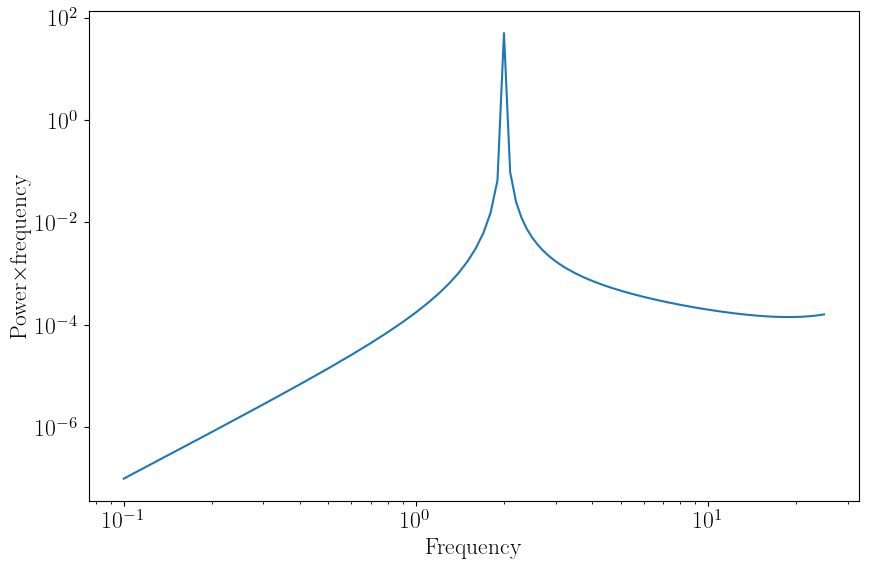

6842

In [2]:
#let us define a grid of 500 time bins, from 0 to 10.
time_res = 500
times = np.linspace(0,10,time_res)
time_bin = np.diff(times)[0]

#from the time grid we just defined, let us define a sinusoidal wave at a 
#frequency of 2Hz
sin_signal = np.sin(2.*np.pi*times/0.5)

#finally, let us initialize our PowerSpectrum object, compute the PSD of our sin 
#wave, and plot the result.
sin_psd = PowerSpectrum(times)
sin_psd.compute_psd(sin_signal)
sin_psd.plot_psd()
gc.collect()

## Defining a power spectrum model in the Fourier domain

It is common for models to be defined in the Fourier, rather than time, domain. In this example we will build such a model, inspired by those used for studying accreting black holes.

First, we need to define a longer array of times, since accreting sources display variability over a wide array of timescales. We then define our model as a sum of two Lorentzian functions, using the ````lorentz```` function from ````nDspec.models````. The first argument of each Lorentzian is the Fourier frequency grid over which the function is defined - in this case, it will be the ````freqs```` attribute stored in the ````psd_model_fft```` ````PowerSpectrum```` object. The second argument is an array of parameters for each Lorentzian - in order, the centroid frequency, Q factor, and rms normalization. We can then assign the sum of the two Lorentzians direcetly to the ````power_spec```` method and plot the result. Because the model is defined in Fourier space, there is no need to call the ````compute_psd```` method to Fourier transform the input.

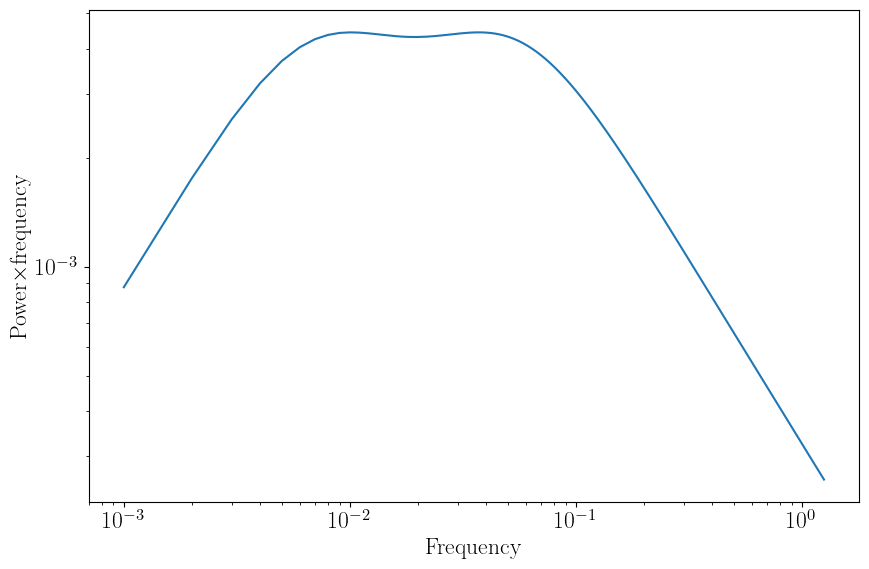

9957

In [3]:
#Define our time grid and power spectrum object
time_res_fft = 2500+1
times_fft = np.linspace(0.1,1.e3,time_res_fft)
psd_model_fft = PowerSpectrum(times_fft)

#Define our model for the power spectrum directly in Fourier space, as a sum of 
#two Lorentzians
centroid_1 = 0.0075
q_1 = 0.1
rms_1 = 0.1
centroid_2 = 0.05
q_2 = 0.1
rms_2 = 0.1
lorentz_fft = models.lorentz(psd_model_fft.freqs,np.array([centroid_1,q_1,rms_1])) + \
              models.lorentz(psd_model_fft.freqs,np.array([centroid_2,q_2,rms_2]))  

#Assign the model array to power_spec and plot the result
psd_model_fft.power_spec = lorentz_fft
psd_model_fft.plot_psd()
gc.collect()

## Setting up a 2d model for a cross spectrum

The cross spectrum in nDspec is handled similarly to the power spectrum, except users also need to specify a grid of energies over which to define a ````CrossSpectrum```` object. 

This example uses the NICER response function to define the energy grid, and shows how to derive standard spectral timing products for an input phenomenological model. First, we read the NICER response using ````astropy```` and initialize the energy grid array ````nicer_en```` at the mid point of each bin in the response. Then, we set up our ````CrossSpectrum```` object by using this energy array together with the same array of times ````times_fft```` as the previous example. 

We now need to initialize three quantites to calculate our cross spectrum. First, we need to store a model in our object. In this example, our model is a pivoting power-law identical to that of the _reltrans_ model (see Mastroserio et al. 2019, Ingram et al. 2019, Mastroserio et al. 2021). In nDspec this model component is included in ````nDspec.models```` and is called ````pivoting_pl````; it is defined in Fourier space as a (complex) transfer function, as a function of energy and Fourier frequency. 

We can initialize this model by passing an array for the Fourier frequencies, one for the energy grid, and one contaiing the actual model parameters. Since this is a model for the transfer function, once the model is initialized it should be stored in our ````CrossSpectrum```` with the ````set_transfer```` method. For more details about a pivoting power-law model, or transfer functions, we recommend users read the papers mentioned above.

Second, we need to assume some shape for the underlying power spectrum that is modulated by our energy-dependent transfer function. For this example, we will utilize the power spectrum defined in the previous section, so we retrieve that array with the ````power_spec```` method of the ````PowerSpectrum```` object and pass it to our new CrossSpectrum object with ````set_psd_weights````.

Finally, we need to set a reference band to compare each energy bin to. For this we will use the entire NICER band, so we pass the first and last elements of the ````nicer_en```` array to our object through the ````set_reference_energy```` method. 

We are now ready to calculate and visualize our model cross spectrum.

In [4]:
#read the NICER response to set up an identical energy array
NICER_rmf = os.getcwd()+"/data/nicer-rmf6s-teamonly-array50.rmf"
response = fits.open(NICER_rmf)
# get all the extension names
extnames = np.array([h.name for h in response])
if "MATRIX" in extnames:
    h = response["MATRIX"]
elif "SPECRESP MATRIX" in extnames:
    h = response["SPECRESP MATRIX"]
data = h.data
energ_lo = np.array(data.field("ENERG_LO"))
energ_hi = np.array(data.field("ENERG_HI"))
nicer_en = (energ_lo+energ_hi)/2.
energy_channels=len(nicer_en)
response.close()

#define the CrossSpectrum object
piv_fft = CrossSpectrum(times_fft,energ=nicer_en)

#calculate up our model, defined in Fourier space, and assign it to the transfer 
#function of our CrossSpectrum object
pl_norm = 1.
pl_slope = -1.9
gamma_nu = 0.2
phi_0 = -0.5
phi_nu = -0.6
nu_0 = piv_fft.freqs[0]
piv_transfer = models.pivoting_pl(piv_fft.freqs,nicer_en,np.array([pl_norm,pl_slope,gamma_nu,phi_0,phi_nu,nu_0]))
piv_fft.set_transfer(piv_transfer)

#pass the cross spectrum, transfer function and reference band to the class
piv_fft.set_psd_weights(psd_model_fft.power_spec)

#set up the reference band
ref_emin = nicer_en[0]
ref_emax = nicer_en[-1]
piv_fft.set_reference_energ([ref_emin,ref_emax])

Having set up our ````CrossSpectrum```` object, we can calculate the cross spectrum predicted by our pivoting power-law model with the ````cross_from_transfer```` method. If we want, we can also specify transfer function, power spectrum, or reference band through the arguments of this method, but in this case we chose to set them beforehand.

Once the crosss spectrum is computed, we can plot the result with the ````plot_cross_2d```` method. By default this method will produce three two-dimensional plots, showing (in order) the logarithm of the modulus, the phase, and the lag (computed from the phase) in the cross spectrum. Alternatively, we can pass the keyword ````form=cartesian```` to plot real and imaginary parts instead.

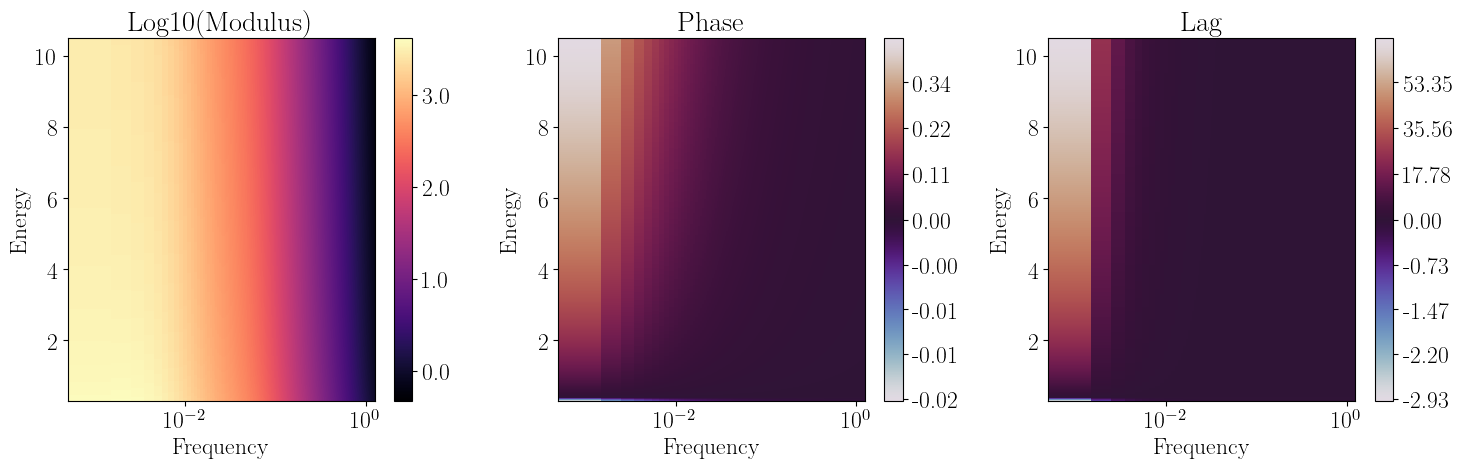

15878

In [5]:
#calculate the cross spectrum and plot it automatically
piv_fft.cross_from_transfer()
piv_fft.plot_cross_2d()
gc.collect()

## Retrieving 1d timing products from a cross spectrum

After computing the two-dimensional cross spectrum, we can derive one dimensional spectral timing products as a function of either frequency or energy. The methods used for retrieving all the products utilize the same convention: "cross spectrum part"\_"desired axis".

In this example, we want to visualize the modulus and lag as a function of frequency first, which are accessed through the ````mod_frequency```` and ````lag_frequency````. Frequency-dependent products require an energy interval for the channel of interest and by default utilize the same reference band as the full, two-dimensional cross spectrum computed above. Users can also specify a different reference band using the ````ref```` keyword, although this should only be done for visualization purposes.

Energy-dependent products are retrieved in the same way. If, for instance, users want to compute the cross spectral modulus and lag as a function of energy, they can do so with the ````mod_energy```` and ````lag_energy```` methods. These also require that users input the Fourier frequency range through the ````nu_min```` and ````nu_max```` arguments. In this example, we take the first decade in Fourier frequency, which is also highlighted in blue in the first two products.

75

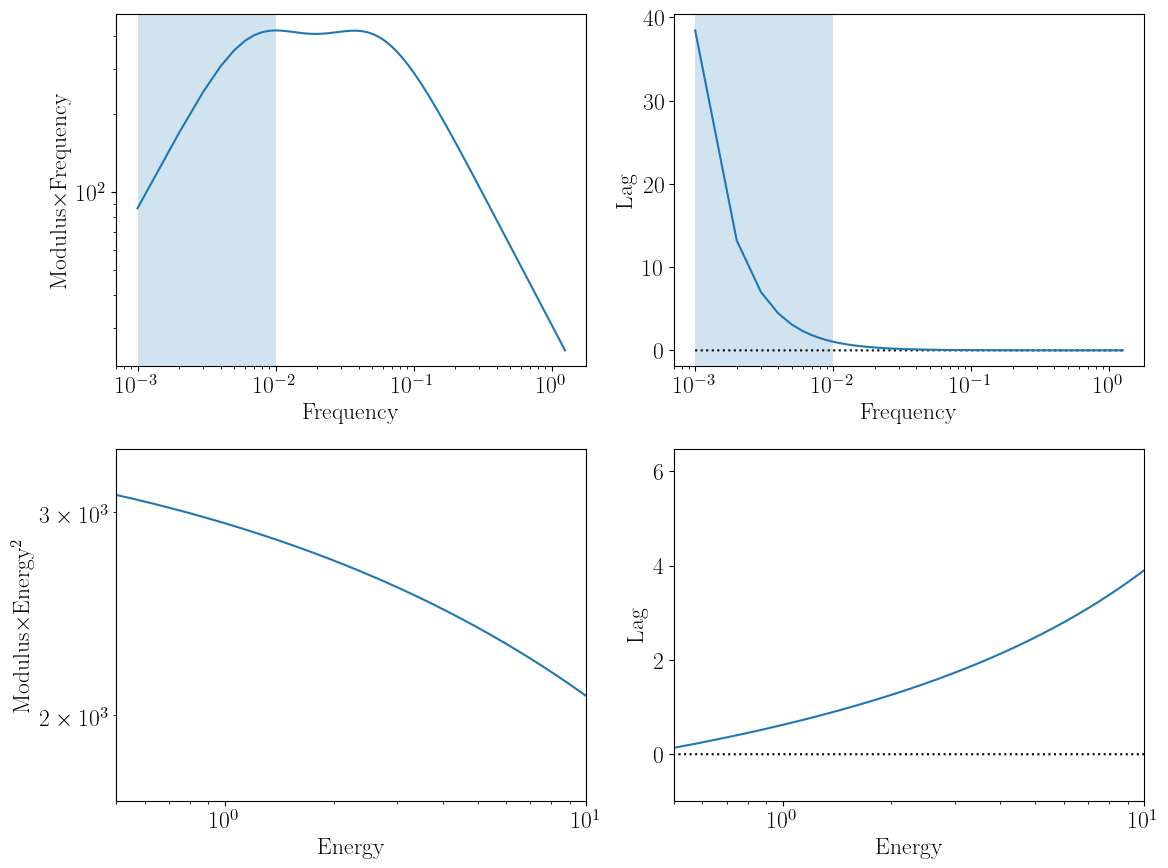

In [6]:
#define our channel of interest for the frequency-dependent spectra
ener_bounds = [3.,5.]

#define our frequency bounds for the lag-dependent spectra
lowfreq_bounds = [piv_fft.freqs[0],10*piv_fft.freqs[0]]

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12.,9.))

ax1.axvspan(piv_fft.freqs[0],10.*piv_fft.freqs[0],alpha=0.2)
#normalize by the Fourier frequency for ease of visualization, similar to common 
#power*frequency plots used for powerspectra
ax1.plot(piv_fft.freqs,piv_fft.mod_frequency(ener_bounds)*piv_fft.freqs)

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Frequency")
ax1.set_ylabel("Modulus$\\times$Frequency")

ax2.axvspan(piv_fft.freqs[0],10.*piv_fft.freqs[0],alpha=0.2)
ax2.plot(piv_fft.freqs,np.zeros(piv_fft.n_freqs),color='black',linestyle='dotted')
ax2.plot(piv_fft.freqs,piv_fft.lag_frequency(ener_bounds))

ax2.set_xscale("log")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Lag")

#normalize by energy^2 for ease of visualization
ax3.plot(piv_fft.energ,piv_fft.mod_energy(lowfreq_bounds)*piv_fft.energ**2)

ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("Energy")
ax3.set_ylabel("Modulus$\\times$Energy$^{2}$")
ax3.set_xlim([0.5,10])

ax4.plot(piv_fft.energ,np.zeros(piv_fft.n_chans),color='black',linestyle='dotted')
ax4.plot(piv_fft.energ,piv_fft.lag_energy(lowfreq_bounds))

ax4.set_xscale("log")
ax4.set_xlabel("Energy")
ax4.set_ylabel("Lag")
ax4.set_xlim([0.5,10])

plt.tight_layout()
gc.collect()

## Calculating a cross spectrum from an impulse response function

It is common to define spectral timing models in the time, rather than Fourier, domain, through the use of an impulse response function (e.g. Campana & Stella 1995, Reynolds et al. 1999, Wilkins & Fabian 2013). In this example we will treat one of the most common uses of model impulse responses: the reverberation of coronal X-ray photons off of the accretion disk surrounding a black hole. 

We will once again use a phenomenological model: a combination of a 0.5 keV black body and 6.5 keV gaussian flashes. For this, we use the ````gauss_bkn```` and ````bbody_bkn```` models in nDspec. With these models, the luminosity of both components follows a broken power-law such that it rises and then drops over time, the line becomes narrower over time, and the black body becomes cooler. This behavior roughly mimics that of relativistic models for reverberation (e.g. Wilkins & Fabian 2013, Mastroserio et al. 2019, Lucchini et al. 2023).

Having set up our model, we can then visualize the impulse response function using the ````plot_2d```` function in ````models````, together with the response integrate over energy (obtaining the lightcurve of the response) or time (obtaining the spectrum of the response). 

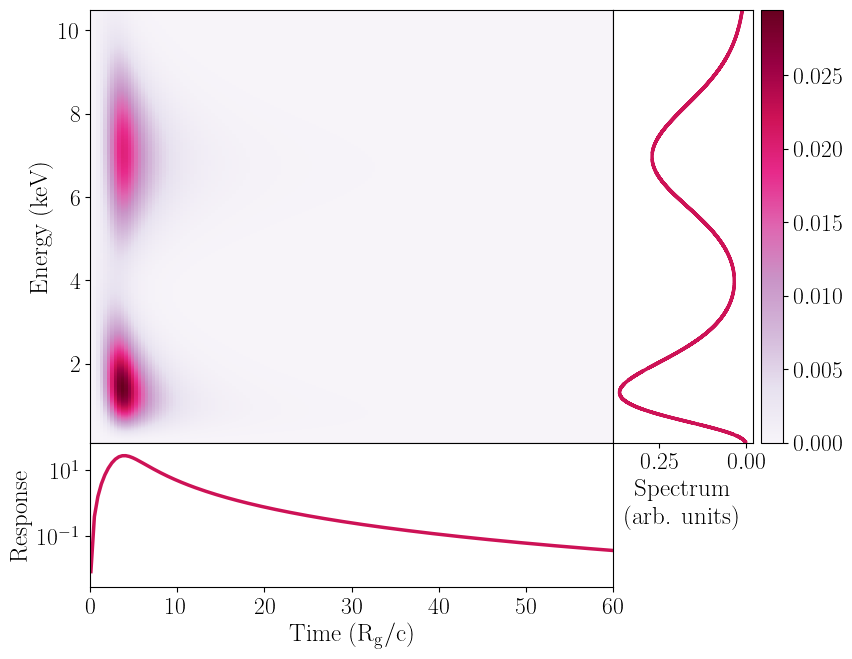

9933

In [7]:
#the initial normalization, center, and initial width of the Gaussian line
gauss_norm = 3e-3
gauss_sigma = 2
gauss_center = 6.5
#the power-;aw slope of the rising and decaying part of the pulse
rise_slope = 2
decay_slope = -3
#the time at which the pulse switches from one slope to the next
peak_time = 4
#the slope of the power-law which sets the width of the line at each time
width_slope = -0.25
gauss_flash, gauss_line, gauss_pulse = models.gauss_bkn(times_fft,nicer_en,
                                                        np.array([gauss_norm,gauss_sigma,gauss_center,rise_slope,
                                                                  decay_slope,peak_time,width_slope]),
                                                        return_full=True)
#the initial normalization and temperature of the blackbody
bb_norm = 1.5e-3
bb_temp = 0.5
#the slope of the power-law which sets the temperature of the blackbody at each time
temp_slope = -0.25
bb_flash, bb_spec, bb_pulse = models.bbody_bkn(times_fft,nicer_en,
                                               np.array([bb_norm,bb_temp,rise_slope,
                                                         decay_slope,peak_time,temp_slope]),
                                                return_full=True)

rev_flash = gauss_flash + bb_flash
rev_spec = gauss_line + bb_spec
rev_pulse = gauss_pulse + bb_pulse

models.plot_2d(times_fft,nicer_en,rev_flash,rev_pulse,rev_spec,xlim=[0,60])
gc.collect()

Having defined an impulse response function, we can then assign it to a newly initialized ````CrossSpectrum```` object, ````rev_ffft````, together with a power spectrum and reference band, as in the previous example.

Because our model is now defined in the time domain, we need to transform it to the Fourier domain before calculating the cross spectrum. Both of these operations are handled by the  ````cross_from_irf```` method, which works similarly to ````cross_from_transfer```` described above. Numerically, the only difference is that ````cross_from_irf```` has to perform a Fourier transform of the input, while ````cross_from_transfer```` does not. Either way, the Fourier-transformed model is assigned to the ````trans_func```` attribute and can be retrieved by the user for future use.

Finally, we can visualize the cross spectrum with ````plot_cross_2d````. Our ````CrosssSpectrum```` object as defined here includes lags (or correlated variability) driven by the reverberation signal itself - for example, as the Gaussian line is narrowing over time, the signal near the core will lag behind that in the wings.

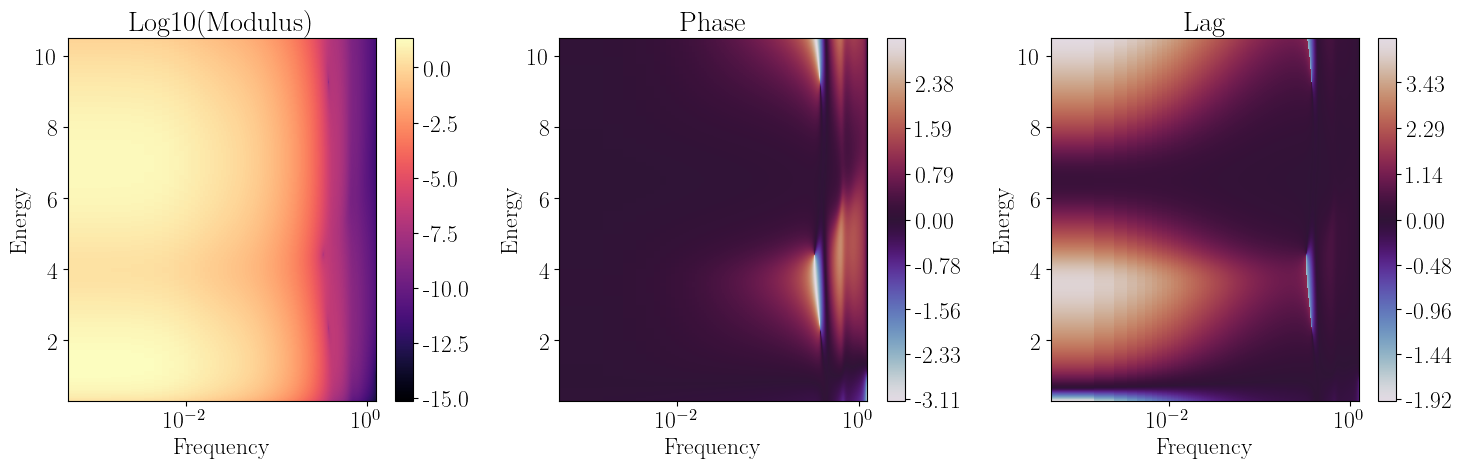

15810

In [8]:
rev_fft = CrossSpectrum(times_fft,energ=nicer_en,method='fft')
rev_fft.set_psd_weights(psd_model_fft.power_spec)
rev_fft.set_impulse(rev_flash)
rev_fft.set_reference_energ([ref_emin,ref_emax])
rev_fft.cross_from_irf()
rev_fft.plot_cross_2d()
gc.collect()

## Combining models for the cross spectrum

One has to be be very careful in interpreting the products of the reverberation model defined above. This is because the ````rev_flash```` model defined above only encodes information (lags and correlated variability) produced within the reverberation. In order to study the causal relationship between an input signal and its reverberation component, we need to define a model for both. We can then take advantage of the linearity of the Fourier transform, sum the two model components, and then compute the cross spectrum.

In this example, we use the transfer function from ````piv_fft```` to model the variability of the accretion flow, and the transfer function from ````rev_fft```` for the reverberation signal; our model will be the sum of the two. We can then simply define a new ````CrossSpectrum```` object, assign to it the sum of the two model transfer functions, and calculate the cross spectrum identically to the previous examples. Our combined model ````full_fft```` now includes the reverberation signal: the lags and correlated variability between the two model components. By definition, a cross spectrum computed from just one of the two will not encode this information.

Note that, even though ````rev_fft```` was initially a time-domain model, we already transformed it to the Fourier domain in the previous step; as a result, we can just call the ````trans_func```` method and utilize ````cross_from_transfer```` to calculate the final cross spectrum.

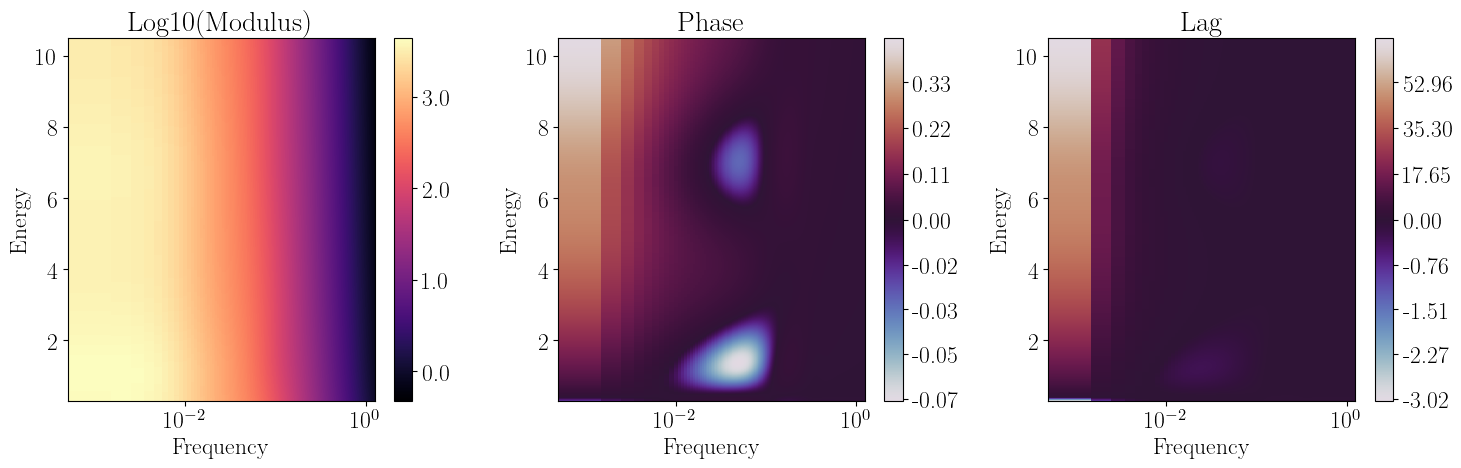

15862

In [9]:
full_fft = CrossSpectrum(times_fft,energ=nicer_en,method='fft')
full_fft.set_psd_weights(psd_model_fft.power_spec)
full_fft.set_transfer(piv_fft.trans_func + rev_fft.trans_func)
full_fft.set_reference_energ([ref_emin,ref_emax])
full_fft.cross_from_transfer()
full_fft.plot_cross_2d()
gc.collect()

Let's now visualize what the lag and modulus spectra (by plotting ````mod_energy```` and ````lag_energy````) are like for our pivoting and combined models. We are especially interested in visualizing how the reverberation signal affects these products, as combining time or Fourier dependent models is not as intuitive as e.g. spectral components for a time averaged model.

For simplicity we will do so in two Fourier frequency bands: the lowest and highest decades probed by our models, shown in the top and bottom rows of the plot below. The typical expectation is that at low frequency we should mostly observe variability in the power-law, with the reverberation signal appearing at high frequencies. 

Comparing the pivoting-only model (in blue) with our pivoting+reverberation model (in orange) shows that the effect of reverberation is more subtle. In the lag spectra (right column), the reverberation features are indeed most visible at high frequency; however, they also affect the shape of the low frequency lag spectrum. The cross spectrum modulus on the other hand behaves in the opposite way: the contribution of reverberation is small but noticeable at low frequencies, and completely unnoticeable at high frequency. 

30039

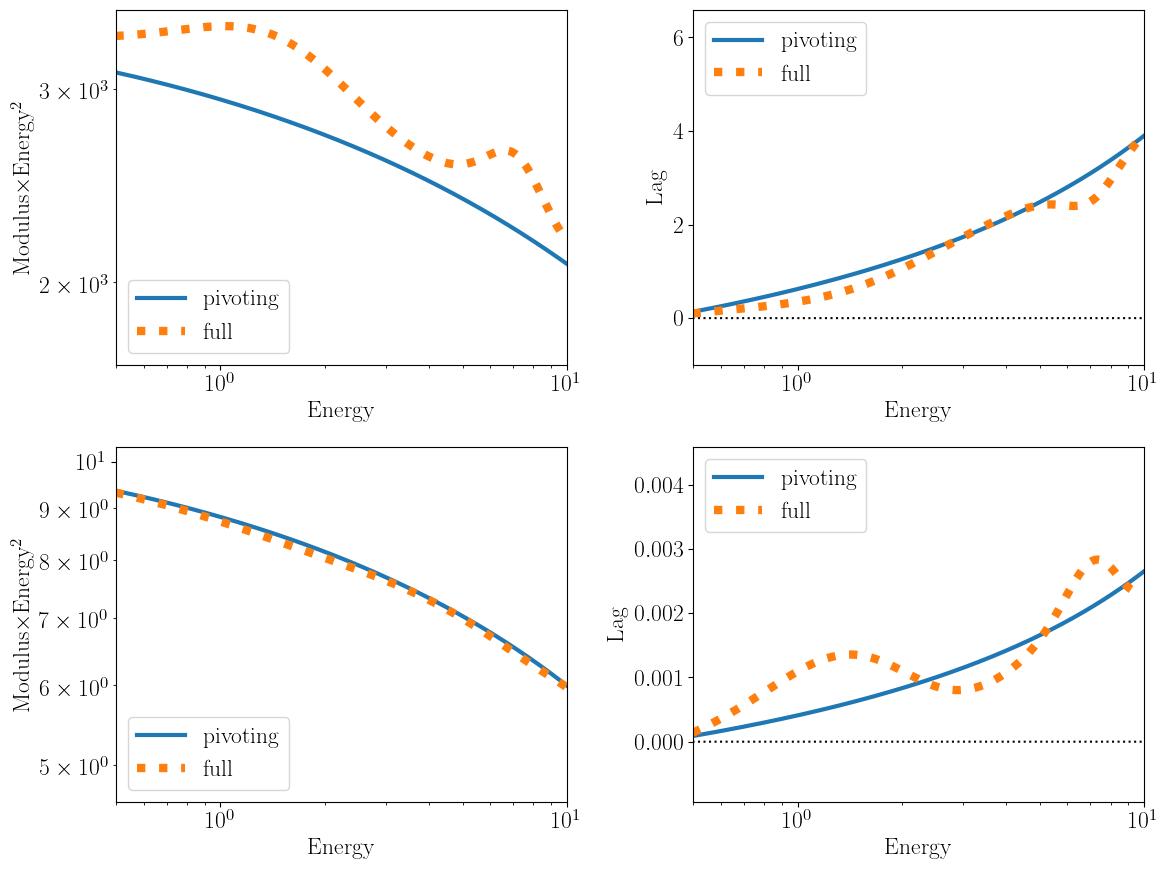

In [10]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12.,9))

ax1.plot(piv_fft.energ,piv_fft.mod_energy(lowfreq_bounds)*piv_fft.energ**2,
         linewidth=3,label='pivoting')
ax1.plot(full_fft.energ,full_fft.mod_energy(lowfreq_bounds)*full_fft.energ**2,
         linewidth=6,linestyle='dotted',label='full')

ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("Energy")
ax1.legend(loc="lower left")
ax1.set_ylabel("Modulus$\\times$Energy$^{2}$")
ax1.set_xlim([0.5,10])

ax2.plot(piv_fft.energ,np.zeros(piv_fft.n_chans),color='black',linestyle='dotted')
ax2.plot(piv_fft.energ,piv_fft.lag_energy(lowfreq_bounds),
         linewidth=3,label='pivoting')
ax2.plot(full_fft.energ,full_fft.lag_energy(lowfreq_bounds),
         linewidth=6,linestyle='dotted',label='full')

ax2.set_xscale("log")
ax2.set_xlabel("Energy")
ax2.set_ylabel("Lag")
ax2.legend(loc="upper left")
ax2.set_xlim([0.5,10])

#define the high frequency bounds
highfreq_bounds = [0.1*piv_fft.freqs[-1],piv_fft.freqs[-1]]

ax3.plot(piv_fft.energ,piv_fft.mod_energy(highfreq_bounds)*piv_fft.energ**2,
         linewidth=3,label='pivoting')
ax3.plot(full_fft.energ,full_fft.mod_energy(highfreq_bounds)*full_fft.energ**2,
         linewidth=6,linestyle='dotted',label='full')

ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("Energy")
ax3.set_ylabel("Modulus$\\times$Energy$^{2}$")
ax3.legend(loc="lower left")
ax3.set_xlim([0.5,10])

ax4.plot(piv_fft.energ,np.zeros(piv_fft.n_chans),color='black',linestyle='dotted')
ax4.plot(piv_fft.energ,piv_fft.lag_energy(highfreq_bounds),
         linewidth=3,label='pivoting')
ax4.plot(full_fft.energ,full_fft.lag_energy(highfreq_bounds),
         linewidth=6,linestyle='dotted',label='full')

ax4.set_xscale("log")
ax4.set_xlabel("Energy")
ax4.set_ylabel("Lag")
ax4.legend(loc="upper left")
ax4.set_xlim([0.5,10])

plt.tight_layout()
gc.collect()

## Folding a cross spectrum through an instrument response

After obtaining our cross spectrum, the last step needed before we can compare a model to data is to fold it through our chosen instrument response, which we can easily do by using a `````ResponseMatrix````` object. 

Calling the ````convolve_response```` method by passing a ````CrossSpectrum```` object will automatically return a new, folded ````CrossSpectrum```` that we can visualize in the usual way. Note that, for example, the modulus of our new object appears to  peak around 1 keV and then drop for increasing energy; this is because it is modulated by NICER effective area.

Arf missing, please load it
Arf loaded


/home/matteo/Software/nDspec/src/ndspec/Timing.py:1601: RuntimeWarning: divide by zero encountered in log10
  modulus = ax1.pcolormesh(self.freqs,self.energ,np.log10(plot_mod),


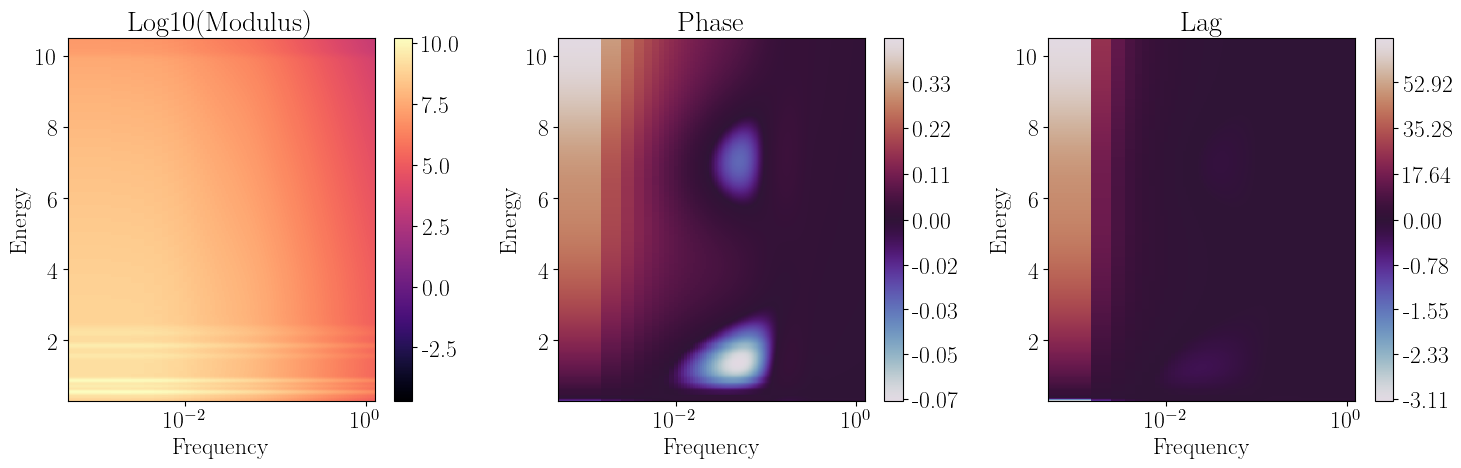

15885

In [11]:
rmfpath = os.getcwd()+"/data/nicer-rmf6s-teamonly-array50.rmf"
nicer_matrix = ResponseMatrix(rmfpath)
arfpath = os.getcwd()+"/data/nicer-consim135p-teamonly-array50.arf"
nicer_matrix.load_arf(arfpath)

convolved_model = nicer_matrix.convolve_response(full_fft)
convolved_model.plot_cross_2d()
gc.collect()

Finally, we can check that our new ````CrossSpectrum```` was indeed re-shaped by the convolution by printing the number of energy channels. The NICER response contains 3451 energy bins and 1501 energy channels, and indeed the ````n_chans```` attribute changes from 3451 for our intiial ````CrossSpectrum```` to 1501 for our folded ````CrossSpectrum````. In the same way, the shape of the ````cross```` attribute, which stores the full cross spectrum, changes from 3451x1250 (energy bins times Fourier frequency bins) to 1501x1250 (energy channels times Fourier frequency bins)

In [12]:
print(full_fft.n_chans,convolved_model.n_chans)
print(full_fft.cross.shape,convolved_model.cross.shape)

3451 1501
(3451, 1250) (1501, 1250)
